In [1]:
import os
from PIL import Image
import numpy as np
import tensorflow as tf
import torch
!pip install lpips
import lpips
from skimage import color
import matplotlib.pyplot as plt
from google.colab import drive

#TODO: Convert from google colab to personal computer for easier usage

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.5 MB/s eta 0:00:00


### If not done already, please place this script along with the DCGAN generator and any pictures you want restored in the same folder. There are noisy pictures available in the folder for use if you have no noisy images of your own.

In [2]:
drive.mount('/content/drive')
DATASET_ROOT = "/content/drive/MyDrive/GAN-results/lambda80_adam0.0001"

pic = input("Please write the name of your picture including file extension i.e. 'picture.png': ")



Mounted at /content/drive
Please write the name of your picture including file extension i.e. 'picture.png': doggo.jpg


### This DCGAN model has been trained on 64x64 images. Your image will be automatically resized.

This is your input picture:


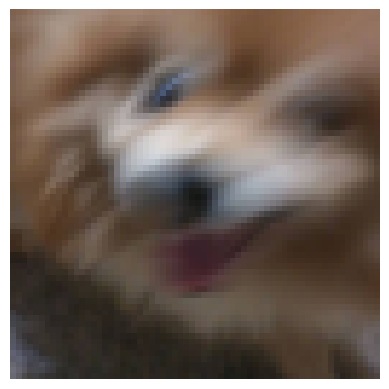

In [6]:
def load_and_prepare(path):
    img = Image.open(path).convert("RGB").resize((64, 64))

    print("This is your input picture:")
    plt.imshow(img)
    plt.axis("off")
    plt.show()

    arr = np.array(img).astype("float32")
    arr = (arr - 127.5) / 127.5

    arr = np.expand_dims(arr, axis=0)
    return arr

pic_prepared = load_and_prepare("/content/drive/MyDrive/GAN_results/doggo.jpg")

### The generator will now be loaded and given your picture for restoration.

This is your restored picture:


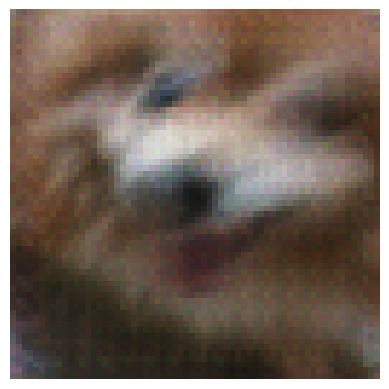

In [11]:
generator = tf.keras.models.load_model("/content/drive/MyDrive/GAN_results/lambda80_adam0.0001/generator.keras")

output = generator(pic_prepared, training=False).numpy()

#Return the array to the form of a picture
output_metrics = output #Save a normalized copy for metrics
output = (output[0] * 127.5 + 127.5).clip(0, 255).astype("uint8")

print("This is your restored picture:")
plt.imshow(output)
plt.axis("off")
plt.show()


In [16]:
def metrics_msssim(original, restored):
    original = (original + 1)/2
    restored = (restored + 1)/2
    original = tf.convert_to_tensor(original, dtype=tf.float32)
    restored = tf.convert_to_tensor(restored, dtype=tf.float32)

    return tf.image.ssim_multiscale(original, restored, max_val=1.0, filter_size=3).numpy()

compare = lpips.LPIPS(net='alex')

def metrics_lpips(original, restored):
    # original and restored are (batch, H, W, C), need to be (batch, C, H, W) for LPIPS
    t1 = torch.tensor(original).permute(0, 3, 1, 2)
    t2 = torch.tensor(restored).permute(0, 3, 1, 2)
    return compare(t1, t2).item()

def metrics_deltaE2000(original, restored):
    original = (original + 1)/2
    restored = (restored + 1)/2
    scale1 = color.rgb2lab(original)
    scale2 = color.rgb2lab(restored)
    delta = color.deltaE_ciede2000(scale1, scale2)
    return np.mean(delta)

value_msssim = metrics_msssim(pic_prepared, output_metrics)
value_lpips = metrics_lpips(pic_prepared, output_metrics)
value_deltaE = metrics_deltaE2000(pic_prepared, output_metrics)

print(value_msssim)
print(value_lpips)
print(value_deltaE)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/alex.pth
[0.9831633]
0.043896354734897614
4.3276854
